In [139]:
import json
import cv2
from matplotlib import pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [140]:
# Paths to COCO annotations (instances_val2017.json) and images (val2017/)
ANNOTATION_PATH = '../../COCO/annotations/instances_val2017.json'
IMG_PATH = '../../COCO/val2017/'

In [141]:
# Chose image to evaluate
# !!! CAN ONLY BE 1 IMAGE !!!
chosen_image_ids = [293390]

# Load file with predictions
json_data = json.loads(open('instances_yolox.json').read())
filtered_detections = [x for x in json_data if x['image_id'] in chosen_image_ids]

# Load file with ground truth
coco_ground_truth = COCO(ANNOTATION_PATH)
coco_predictions = coco_ground_truth.loadRes('instances_yolox.json')

# Run COCO evaluation
coco_eval = COCOeval(coco_ground_truth, coco_predictions, 'bbox')
coco_eval.params.imgIds = chosen_image_ids
coco_eval.evaluate()
coco_eval.accumulate()


loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.01s).


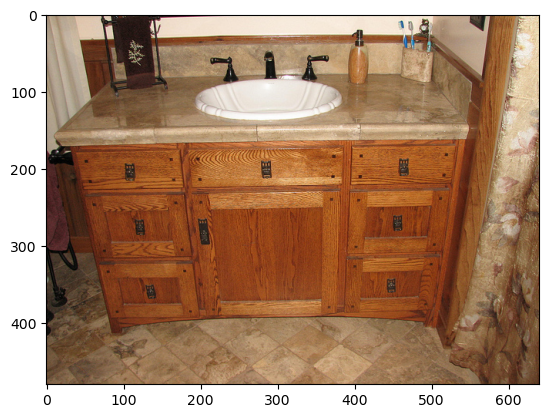

In [142]:
img_id = str(filtered_detections[0]['image_id']).rjust(12, '0')
img_path = '../../COCO/val2017/' + img_id + '.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

PREDICTIONS:
Label: 81, bbox: [193.4182739258, 81.1504598764, 191.4924973708, 59.7346731333]
Label: 44, bbox: [283.0132117638, 48.0298277048, 16.3482666016, 35.800812061]
GROUND TRUTH:
Label: 44, bbox: [392.28, 21.21, 26.87, 69.71]
Label: 90, bbox: [457.04, 8.69, 12.07, 35.68]
Label: 90, bbox: [469.75, 9.23, 8.19, 36.65]
Label: 90, bbox: [494.62, 11.04, 7.56, 38.42]
Label: 81, bbox: [192.36, 84.02, 193.44, 54.41]
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.300
 Average Recall     (A

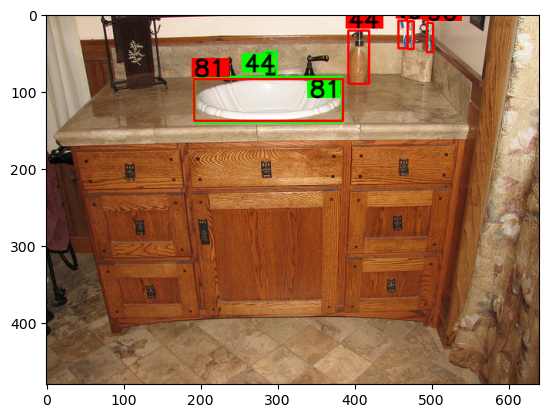

In [143]:
print('PREDICTIONS:')

for detection in filtered_detections:
    label = detection['category_id']
    bbox = detection['bbox']

    # Draw bounding box
    x_min,y_min,width,height = bbox
    x_max = x_min + width
    y_max = y_min + height
    cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    # Draw label
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    detection_info = f'{label}'
    label_size = cv2.getTextSize(detection_info, font_face, font_scale, font_thickness)[0]
    label_x_min, label_y_min = int(x_max - label_size[0] - 3), int(y_min + 3)
    label_x_max, label_y_max = int(x_max - 3), int(y_min + 5 + label_size[1])
    cv2.rectangle(img, (label_x_min, label_y_min), (label_x_max, label_y_max), (0,255,0), -1)
    cv2.putText(img, detection_info, (int(x_max - label_size[0]), int(y_min) + 4 + label_size[1]), font_face, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)

    print(f'Label: {label}, bbox: {bbox}')

gt_label = coco_ground_truth.loadAnns(coco_ground_truth.getAnnIds(imgIds=[int(img_id)]))
print('GROUND TRUTH:')
for label in gt_label:
    bbox = label['bbox']
    label = label['category_id']

    # Draw bounding box
    x_min,y_min,width,height = bbox
    x_max = x_min + width
    y_max = y_min + height
    cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)

    # Draw label
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    detection_info = f'{label}'
    label_size = cv2.getTextSize(detection_info, font_face, font_scale, font_thickness)[0]
    label_x_min, label_y_min = int(x_min - 3), int(y_min - 3)
    label_x_max, label_y_max = int(x_min + 3 + label_size[0]), int(y_min - 5 - label_size[1])
    cv2.rectangle(img, (label_x_min, label_y_min), (label_x_max, label_y_max), (255,0,0), -1)
    cv2.putText(img, detection_info, (int(x_min), int(y_min) - 4), font_face, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)

    print(f'Label: {label}, bbox: {bbox}')

plt.imshow(img)

# Display evaluation results
coco_eval.summarize()

In [144]:

import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from yolox import yolox_inference
from matplotlib import pyplot as plt

ANNOTATION_PATH = '/home/pwl/Projects/tiny-tracking/COCO/annotations/instances_val2017.json'
IMG_PATH = '/home/pwl/Projects/tiny-tracking/COCO/val2017'
coco_ground_truth = COCO(ANNOTATION_PATH)

results = list()

# for image_name in tqdm(os.listdir(IMG_PATH)):
#     image_id = int(image_name.split('.')[0])
#     dets = yolox_inference(os.path.join(IMG_PATH, image_name))
#     for det in dets:
#         bbox = det[0:4]
#         x_min, y_min, x_max, y_max = bbox
#         width = x_max - x_min
#         height = y_max - y_min
#         coco_bbox = [x_min, y_min, width, height]
#         score = det[4]
#         class_id = det[5]
#         pred = {
#             'image_id': image_id,
#             'category_id': int(class_id),
#             'bbox': [round(float(coord), 10) for coord in coco_bbox],
#             'score': float(score)
#         }
#         results.append(pred)

# with open('instances_yolox.json', 'w') as f:
#     json.dump(results, f)

coco_predictions = coco_ground_truth.loadRes('instances_yolox.json')

coco_eval = COCOeval(coco_ground_truth, coco_predictions, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()




loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.87s).
Accumulating evaluation results...
DONE (t=1.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

AOC:  0.6196458677954408 0.5061041031284548 0.03419420462856772


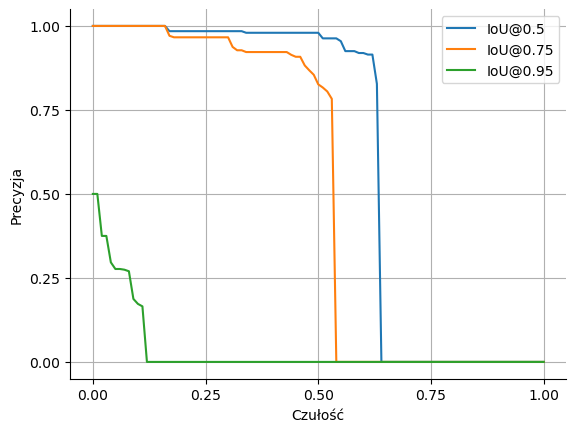

In [173]:
all_precision = coco_eval.eval['precision']

"""
    all_precision = [T, R, K, A, M]

    T: len([.5:.05:1.0]) the 10 IoU Thresholds
    R: len([0:0.01:1]) the 100 Recall Thresholds
    K: Number of classes (80 total; index 0 is person) 
    A: A=4 which corresponds to the object area ranges (0 - all, 1 - small, 2 - medium, 3 - large)
    M: maxDets parameter (0 = 1, 1 = 10, 2 = 100)
"""
pr_5 = all_precision[0, :, 6, 0, 2] # IoU@0.5
pr_7 = all_precision[5, :, 6, 0, 2] # IoU@0.75
pr_9 = all_precision[9, :, 6, 0, 2] # IoU@0.95

x = np.arange(0, 1.01, 0.01)

ax = plt.subplot(111)

ax.plot(x, pr_5, label='IoU@0.5')
ax.plot(x, pr_7, label='IoU@0.75')
ax.plot(x, pr_9, label='IoU@0.95')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.25))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.25))
ax.grid()
ax.spines[['right', 'top']].set_visible(False)

# Area under curves
area_5 = np.trapz(pr_5, x)
area_7 = np.trapz(pr_7, x)
area_9 = np.trapz(pr_9, x)
print("AOC: ", area_5, area_7, area_9)

plt.xlabel('Czułość')
plt.ylabel('Precyzja')
plt.legend()

plt.show(ax)